<a href="https://colab.research.google.com/github/JWuzyk/ML-Lab-Facial-Keypoint-Detection/blob/master/Machine_Learning_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sections:
  - Preprocessing: Contrast Equalization
  - Data Augmentation:  (Reflection, Rotation, Contrast Normalization)
  
      -Ref :https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html 
      
  - Different Models for each keypoint
  - Transfer Learning: VGGFace and Xception 
  
      -Ref https://keras.io/applications/ https://github.com/rcmalli/keras-vggface
  - Hyperparameter Tuning either sklearn https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ or with Tensorboard  see https://www.youtube.com/watch?v=BqgTU7_cBnk (learing rate, optimiser, augmentation ) + saving model weights. Now using hyperas.
  - Set up Kaggle submission
  - Use an emsemble model
  - Find More Data e.g. http://www.milbo.org/muct/, https://github.com/soheillll/Facial-Keypoint-Detection ,https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints, http://umdfaces.io/

Stretch Goals
  - Combine with face detection and apply to other images
  
Challenge:
  - Lots of the data is missing values so we can't train on all of it and there is no sensible way to fill in missing data
  
Solution: 
  - Train individual models for each feature
  
Resources:
  -http://cs231n.stanford.edu/reports/2016/pdfs/010_Report.pdf ; basically a paper by someone doing exactly what we are doing

# Data

## Load data



In [0]:
# Load from github
%cd\

!git clone https://github.com/JWuzyk/ML-Lab-Facial-Keypoint-Detection/
%cd ML-Lab-Facial-Keypoint-Detection/ 

!unzip data/test.zip 
!unzip data/training.zip

!ls


/root
Cloning into 'ML-Lab-Facial-Keypoint-Detection'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 6), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
/root/ML-Lab-Facial-Keypoint-Detection
Archive:  data/test.zip
  inflating: test.csv                
Archive:  data/training.zip
  inflating: training.csv            
data  Machine_Learning_Lab_Project.ipynb  README.md  test.csv  training.csv


In [7]:
#Reading in the data from my drive as pandas Dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IDLookupTable = pd.read_csv('data/IdLookupTable.csv')
training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

FileNotFoundError: ignored

## Data Processing functions

In [0]:
def unpack_Test(sel):
  images = sel.iloc[:,-1]
  images = images.apply(lambda n: np.fromstring(n, dtype = int, sep=' '))
  images = np.vstack(images.values)
  images = images.reshape(images.shape[0],96,96)
  
  # Change into array with shape (-,96,96,3), 
  ret = np.empty((*images.shape, 3), dtype=np.uint8)
  ret[:, :, :,:] = images[:,:, :, np.newaxis]
  images = ret
  
  return images

#separate_data gets rid of the rows containing nan values for subsection of Data_Frame between col1 and col2


def separate_data(df, col1, col2):
  sel = df.dropna(subset=[*df.columns[col1:col2]])
  sel = sel.reset_index(drop=True)
  
  keys = sel.iloc[:,col1:col2]
  keys = keys.to_numpy()
  
  images = sel.iloc[:,-1]
  images = images.apply(lambda n: np.fromstring(n, dtype = int, sep=' '))
  images = np.vstack(images.values)
  images = images.reshape(images.shape[0],96,96)
  
  # Change into array with shape (-,96,96,3), 
  ret = np.empty((*images.shape, 3), dtype=np.uint8)
  ret[:, :, :,:] = images[:,:, :, np.newaxis]
  images = ret
  
  return images,keys

#normalise the data
def normalize(x, y):
  x = x/255
  y = y/96
  return (x, y)

In [0]:
#Method to equalize contrast

from skimage import data, img_as_float
from skimage import exposure

  
def equalize(images):
  return exposure.equalize_hist(images)
  
  

## Data Augmentation functions

In [0]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

# Data Augmentation 

def generate(x,y):
  images = (x).astype(np.uint8)
  keys = y
  #ia.imshow(image)

  n_images = images.shape[0]
  n_keys = keys.shape[1]//2

  keys = keys.reshape(n_images,n_keys,2)

  keypoints = []
  for k in range(n_images):
    kps = KeypointsOnImage([Keypoint(*keys[k,i,:]) for i in range(n_keys)], shape=images.shape)
    keypoints.append(kps)

  # rotate each image some angle between -30 and 30 degrees and flip horizontaly 50% of the time
  seq = iaa.Sequential([
      iaa.Affine(rotate=(-30,30)),
      iaa.Fliplr(0.5)
  ])

  image_aug, kps_aug = seq(images=images, keypoints=keypoints)

  # image with keypoints before/after augmentation (shown below)
  #image_before = keypoints[30].draw_on_image(images[30], size=2)
  #image_after = kps_aug[30].draw_on_image(image_aug[30], size=2)
  #ia.imshow(image_before)
  #ia.imshow(image_after)

  keys_aug = np.array([keypoints[i].to_xy_array() for i in range(len(keypoints))]).reshape(len(keypoints),n_keys*2)


  # add augmented data to training data
  x_train = np.concatenate((x,image_aug))
  y_train = np.concatenate((y,keys_aug))
  
  return image_aug,keys_aug

def augment(x_train,y_train, x_add, y_add):
  x_ret = np.concatenate((x_train,x_add))
  y_ret = np.concatenate((y_train,y_add))
  return x_ret,y_ret

In [0]:
#Contrast Jittering
def aug_contrast(x,y):
  images = (x).astype(np.uint8)
  keys = y
  #ia.imshow(image)

  n_images = images.shape[0]
  n_keys = keys.shape[1]//2

  keys = keys.reshape(n_images,n_keys,2)

  keypoints = []
  for k in range(n_images):
    kps = KeypointsOnImage([Keypoint(*keys[k,i,:]) for i in range(n_keys)], shape=images.shape)
    keypoints.append(kps)

  # rotate each image some angle between -30 and 30 degrees and flip horizontaly 50% of the time
  seq = iaa.Sequential([
      iaa.ContrastNormalization((0.5,1.5))
  ])

  image_aug, kps_aug = seq(images=images, keypoints=keypoints)

  # image with keypoints before/after augmentation (shown below)
  #image_before = keypoints[30].draw_on_image(images[30], size=2)
  #image_after = kps_aug[30].draw_on_image(image_aug[30], size=2)
  #ia.imshow(image_before)
  #ia.imshow(image_after)

  keys_aug = np.array([keypoints[i].to_xy_array() for i in range(len(keypoints))]).reshape(len(keypoints),n_keys*2)


  # add augmented data to training data
  x_train = np.concatenate((x,image_aug))
  y_train = np.concatenate((y,keys_aug))
  
  return image_aug,keys_aug


## Set data

In [0]:
from sklearn.model_selection import train_test_split

def set_data(data_sel, aug = True):
  x_train, y_train = data_sel
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, shuffle= True)

  if aug:
    x_new, y_new = aug_contrast(x_train, y_train)
    x_train, y_train = augment(x_train, y_train, x_new, y_new)

    x_new, y_new = generate(x_train, y_train)
    x_train, y_train = augment(x_train, y_train, x_new, y_new)
  
  x_train,_ = normalize(x_train, y_train)
  x_valid,_ = normalize(x_valid, y_valid)
  
  return x_train, y_train, x_valid, y_valid
 

In [0]:
#get data after getting rid of incomplete rows
data_all = separate_data(training, 0, 30)

#set data without augmenting
x_train, y_train, x_valid, y_valid = set_data(data_all, aug=False)

#set data and augment (drops out any incomplete data rows)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug = set_data(data_all)

In [0]:
# x_train, y_train, x_valid, y_valid = eye_center

In [0]:
# eye_corner = separate_data(training, 4, 12)
# eye_corner = set_data(eye_corner)

# eyebrow  = separate_data(training, 12, 20)
# eyebrow = set_data(eyebrow)

In [0]:
# nose_tip = separate_data(training, 20, 22)
# nose_tip = set_data(nose_tip)

# mouth_corner_top = separate_data(training, 22, 28)
# mouth_corner_top = set_data(mouth_corner_top)

# mouth_center_bottom_lip = separate_data(training, 28, 30)
# mouth_center_bottom_lip = set_data(mouth_center_bottom_lip)

# Plotting functions

In [0]:
from PIL import Image

#Turning the data from a dataframe into x_train,y_train, x_test numpy arrays so that we can use it
# x_train has shape (2140,96,96,3) 2140 images each 96x96 with 3 colour channels, y_train has shape (2140,30), in the form (x_1,y_1,...x_15,y_15) for the 15 keypoints

# Copied the getimage method from https://github.com/shichaoji/img_extract/blob/master/img_extract.py

# Takes a string representing a 96x96 image as in the last column of the training.csv and returns a PIL image
def getimage(each):
    img = Image.new( 'RGB', (96,96), "black") 
    pixels = img.load() # create the pixel map
    
    cot=[int(i) for i in each.split(' ')]
    for i in range(img.size[0]):    # for every pixel:
        for j in range(img.size[1]):
            pixels[i,j] = (cot[i+j*96],cot[i+j*96],cot[i+j*96]) # set the colour accordingly
            
    return img

In [0]:
from PIL import ImageDraw

def plotWithKeypoints1(data):
  key = np.array(data.iloc[:-1])
  key = key.astype(int).reshape(15,2)
  
  im = getimage(data['Image'])
  
  draw = ImageDraw.Draw(im)
  for x,y in zip(key[:,0],key[:,1]):
    draw.ellipse((x-1, y-1, x+1, y+1),fill = 'blue')
  return im


def plotWithKeypoints2(im,key): 
  key = key.astype(int).reshape(15,2)
  img = getimage(im)
  draw = ImageDraw.Draw(img)
  for x,y in zip(key[:,0],key[:,1]):
    draw.ellipse((x-1, y-1, x+1, y+1),fill = 'blue')
  
  return img

plotWithKeypoints1(training.iloc[100,:])

NameError: ignored

In [0]:
#Code adapted from sheet 4 to plot history
def plot_history(history):
    """Create a plot showing the training history of `model.fit`.
    
    Example:
        history = model.fit(...)
        plot_history(history)
    """

    plt.style.use("seaborn-poster")
    x = range(history.params['epochs'])
    f, axarr = plt.subplots(1, sharex=True)
    
    loss, val_loss = history.history['loss'], history.history.get('val_loss')
    axarr.set_title('loss')
    axarr.plot(x, loss, label='train')
    if val_loss:
        axarr.plot(x, val_loss, label='validation')
    axarr.legend()

# Create and Train model

In [0]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


## **Home-made Model**

In [0]:
# normal learning
def make_model_custom(n_keys,image_shape = (96,96,3)):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=image_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_keys))
  model.add(Activation('linear'))
  return model

In [0]:
our_model =  make_model_custom(30)
our_model.compile(optimizer = 'adam', loss='mean_squared_error',metrics =["mean_squared_error"])

W0715 20:08:34.109055 139674805008256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 20:08:34.159047 139674805008256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 20:08:34.168181 139674805008256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 20:08:34.223776 139674805008256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0715 20:08:34.227318 139674805008256 deprecation_wrapp

In [0]:
#General model fitting
our_history = model.fit(x_train_aug, y_train_aug, batch_size=32, epochs=50, validation_data=(x_valid_aug, y_valid_aug))

W0715 20:08:41.811326 139674805008256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1433 samples, validate on 707 samples
Epoch 1/50
1433/1433 [==============================] - 11s 7ms/step - loss: 484.7587 - mean_squared_error: 484.7587 - val_loss: 187.2354 - val_mean_squared_error: 187.2354
Epoch 2/50
1433/1433 [==============================] - 4s 3ms/step - loss: 119.2325 - mean_squared_error: 119.2325 - val_loss: 153.9375 - val_mean_squared_error: 153.9375
Epoch 3/50
1433/1433 [==============================] - 4s 3ms/step - loss: 82.4333 - mean_squared_error: 82.4333 - val_loss: 93.3909 - val_mean_squared_error: 93.3909
Epoch 4/50
1433/1433 [==============================] - 4s 3ms/step - loss: 71.6482 - mean_squared_error: 71.6482 - val_loss: 174.4840 - val_mean_squared_error: 174.4840
Epoch 5/50
1433/1433 [==============================] - 4s 3ms/step - loss: 56.9122 - mean_squared_error: 56.9122 - val_loss: 202.2600 - val_mean_squared_error: 202.2600
Epoch 6/50
1433/1433 [==============================] - 4s 3ms/step - loss: 51.1046 - mean_squared_e

In [0]:
#Model fitting with early stopping
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only = True)

our_history_es = model.fit(x_train_aug, y_train_aug, batch_size=32, epochs=1000, validation_data = (x_valid_aug, y_valid_aug),callbacks =[es, mc])

Train on 9424 samples, validate on 4642 samples
Epoch 1/100
9424/9424 [==============================] - 24s 3ms/step - loss: 22.6180 - mean_squared_error: 22.6180 - val_loss: 9.5579 - val_mean_squared_error: 9.5579
Epoch 2/100
  64/9424 [..............................] - ETA: 20s - loss: 17.7720 - mean_squared_error: 17.7720

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_mse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


9424/9424 [==============================] - 24s 3ms/step - loss: 22.6275 - mean_squared_error: 22.6275 - val_loss: 10.8215 - val_mean_squared_error: 10.8215
Epoch 3/100
9424/9424 [==============================] - 24s 3ms/step - loss: 21.9385 - mean_squared_error: 21.9385 - val_loss: 9.4032 - val_mean_squared_error: 9.4032
Epoch 4/100
9424/9424 [==============================] - 24s 3ms/step - loss: 22.0473 - mean_squared_error: 22.0473 - val_loss: 9.4664 - val_mean_squared_error: 9.4664
Epoch 5/100
9424/9424 [==============================] - 24s 3ms/step - loss: 22.0436 - mean_squared_error: 22.0436 - val_loss: 12.4242 - val_mean_squared_error: 12.4242
Epoch 6/100
9424/9424 [==============================] - 24s 3ms/step - loss: 21.9316 - mean_squared_error: 21.9316 - val_loss: 9.4219 - val_mean_squared_error: 9.4219
Epoch 7/100
9424/9424 [==============================] - 24s 3ms/step - loss: 21.7505 - mean_squared_error: 21.7505 - val_loss: 9.2658 - val_mean_squared_error: 9.2658


## Homemade Model & Hyperas

In [0]:
from keras.models import load_model

# from google.colab import drive
# drive.mount('/gdrive')
# %ls /gdrive


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/


In [0]:
%cd 'ML-Lab-Facial-Keypoint-Detection'

/gdrive/My Drive/Colab Notebooks/ML-Lab-Facial-Keypoint-Detection


In [0]:
hyp_model = load_model('Models/hyperas_custom_untrained.h5')
hyp_model.layers.pop()
hyp_model.layers.pop()
hyp_model.add(Dense(30))
hyp_model.add(Activation('linear'))


#Early Stopping
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only = True)

hyp_history = hyp_model.fit(x_train_aug, y_train_aug, batch_size=64, epochs=1000, validation_data = (x_valid_aug, y_valid_aug), callbacks =[es, mc])


W0715 18:52:28.556824 140478390179712 nn_ops.py:4224] Large dropout rate: 0.662602 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 5735 samples, validate on 2825 samples
Epoch 1/1000
5735/5735 [==============================] - 16s 3ms/step - loss: 255.3106 - mean_squared_error: 255.3106 - val_loss: 25.2189 - val_mean_squared_error: 25.2189
Epoch 2/1000
  64/5735 [..............................] - ETA: 9s - loss: 42.1576 - mean_squared_error: 42.1576

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_mse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5735/5735 [==============================] - 11s 2ms/step - loss: 22.7018 - mean_squared_error: 22.7018 - val_loss: 10.9499 - val_mean_squared_error: 10.9499
Epoch 3/1000
5735/5735 [==============================] - 11s 2ms/step - loss: 20.9980 - mean_squared_error: 20.9980 - val_loss: 11.0776 - val_mean_squared_error: 11.0776
Epoch 4/1000
5735/5735 [==============================] - 11s 2ms/step - loss: 19.6558 - mean_squared_error: 19.6558 - val_loss: 10.8227 - val_mean_squared_error: 10.8227
Epoch 5/1000
5735/5735 [==============================] - 11s 2ms/step - loss: 19.3956 - mean_squared_error: 19.3956 - val_loss: 11.7528 - val_mean_squared_error: 11.7528
Epoch 6/1000
5735/5735 [==============================] - 11s 2ms/step - loss: 19.2130 - mean_squared_error: 19.2130 - val_loss: 11.6234 - val_mean_squared_error: 11.6234
Epoch 7/1000
5735/5735 [==============================] - 11s 2ms/step - loss: 19.4139 - mean_squared_error: 19.4139 - val_loss: 11.6441 - val_mean_squared_er

In [0]:
#Model from Hyperas + nonaugmented data, run on the augmented data for 1000 epochs with early stopping, patience 100
hyp_model.save(hyperas_custom_1000,include_optimizer = True)

# Transfer Learning

## **Xception based model**

In [0]:
# Transfer learning based on https://keras.io/applications/


def make_model_Xception(n_keys):
  # Create a model based on transfer learning from one of the built in keras models, note this section uses the functional API not Sequential model
  # Xception is a cool model see https://www.youtube.com/watch?v=KfV8CJh7hE0
  
  #importing the base model, should double check that the input is fine
  base_model = Xception(weights='imagenet', include_top=False)
  x = base_model.output
  
  # add a Global Average Pooling for some reason
  x = GlobalAveragePooling2D()(x)
  
  # add a dense layer
  x = Dropout(0.3)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  # a dense layer to compute the predicted keypoints
  coords = Dense(n_keys, activation='linear')(x)
  model = Model(inputs=base_model.input, outputs=coords)
  
  return model

In [0]:
Xception_model =  make_model_Xception(30)
Xception_model.compile(optimizer = 'adam',loss='mean_squared_error')
historyX = Xception_model.fit(x_train_aug,y_train_aug, batch_size=32, epochs=10, validation_data=(x_valid_aug, y_valid_aug))

W0715 12:59:25.723052 140636468389760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



83689472/83683744 [==============================] - 5s 0us/step
Train on 1433 samples, validate on 707 samples
Epoch 1/10
1433/1433 [==============================] - 17s 12ms/step - loss: 1072.0560 - val_loss: 1552.1148
Epoch 2/10
1433/1433 [==============================] - 7s 5ms/step - loss: 32.7982 - val_loss: 129.1721
Epoch 3/10
1433/1433 [==============================] - 7s 5ms/step - loss: 24.1588 - val_loss: 54.2010
Epoch 4/10
1433/1433 [==============================] - 7s 5ms/step - loss: 21.8582 - val_loss: 26.7793
Epoch 5/10
1433/1433 [==============================] - 7s 5ms/step - loss: 21.6888 - val_loss: 28.2005
Epoch 6/10
1433/1433 [==============================] - 7s 5ms/step - loss: 19.0923 - val_loss: 13.4950
Epoch 7/10
1433/1433 [==============================] - 7s 5ms/step - loss: 18.4681 - val_loss: 17.4137
Epoch 8/10
1433/1433 [==============================] - 7s 5ms/step - loss: 19.0043 - val_loss: 18.5432
Epoch 9/10
1433/1433 [===========================

In [0]:
plot_history(historyX)

## **VGG Model**

In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
  
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, MaxPooling2D, Dropout
from keras_vggface.vggface import VGGFace

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-yk_0vc2t
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-yk_0vc2t
  Stored in directory: /tmp/pip-ephem-wheel-cache-h32dy1lj/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
#function to give a model based on vgg face
def make_model_VGGFace(n_keys):

    vgg_model = VGGFace(include_top=False, input_shape=(96, 96,3), weights = 'vggface')
    x = vgg_model.get_layer('pool5').output
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)      
    out = Dense(n_keys, activation='linear')(x)

    model = Model(vgg_model.input, output = out)    
    
    model.compile(optimizer='Adam',
                  loss='mean_squared_error',
                  metrics =['mse'])


    return model

In [0]:
vggmodel =  make_model_VGGFace(30)

W0716 09:17:42.888578 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 09:17:42.927136 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 09:17:42.935550 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 09:17:43.137256 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58916864/58909280 [==============================] - 1s 0us/step


W0716 09:17:44.385881 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0716 09:17:44.387642 140563152787328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0716 09:17:47.314482 140563152787328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(T

In [0]:
#See how good the model looks

history_vgg = vggmodel.fit(x_train,y_train, batch_size=64, epochs=20, validation_data=(x_valid, y_valid))

Train on 1433 samples, validate on 707 samples
Epoch 1/20
1433/1433 [==============================] - 17s 12ms/step - loss: 5269.3085 - mean_squared_error: 5269.3085 - val_loss: 1394.0059 - val_mean_squared_error: 1394.0059
Epoch 2/20
1433/1433 [==============================] - 9s 6ms/step - loss: 579.5496 - mean_squared_error: 579.5496 - val_loss: 144.9089 - val_mean_squared_error: 144.9089
Epoch 3/20
1433/1433 [==============================] - 9s 6ms/step - loss: 232.1582 - mean_squared_error: 232.1582 - val_loss: 120.8122 - val_mean_squared_error: 120.8122
Epoch 4/20
1433/1433 [==============================] - 9s 6ms/step - loss: 172.2064 - mean_squared_error: 172.2064 - val_loss: 101.0186 - val_mean_squared_error: 101.0186
Epoch 5/20
1433/1433 [==============================] - 9s 6ms/step - loss: 145.7238 - mean_squared_error: 145.7238 - val_loss: 101.5583 - val_mean_squared_error: 101.5583
Epoch 6/20
1433/1433 [==============================] - 9s 6ms/step - loss: 145.6044 - 

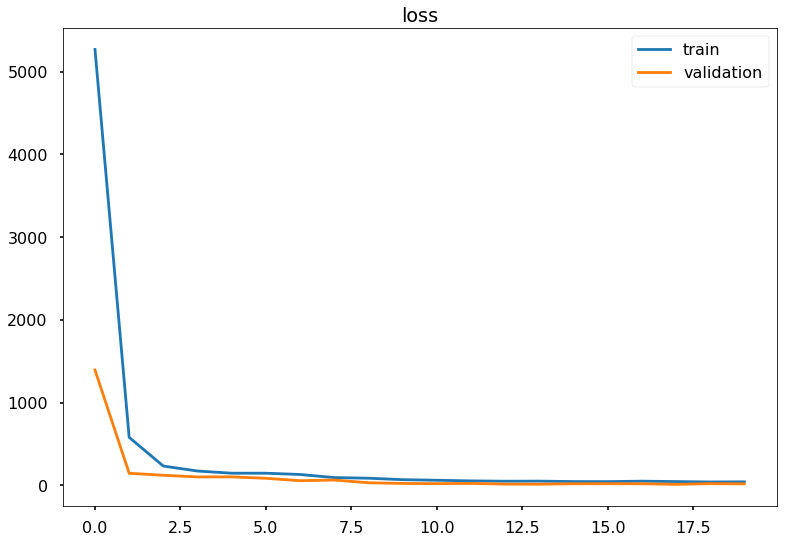

In [0]:
plot_history(history_vgg)

In [0]:
%cd /gdrive/My Drive/Lab Project
!ls

/gdrive/My Drive/Lab Project
 facial-keypoints-detection
 haarcascade_frontalface_alt.xml
 Jan_selfie.jpg
 ML-Lab-Facial-Keypoint-Detection
 Sub15_20_15.csv
 Sub15_20_42.csv
 Sub15_21_57.csv
 Sub.csv
'Subtime.struct_time(tm_year=2019, tm_mon=7, tm_mday=15, tm_hour=20, tm_min=38, tm_sec=51, tm_wday=0, tm_yday=196, tm_isdst=0).csv'
 VGGBest1


In [0]:
import time
from keras.models import load_model

best_vgg = load_model('VGGBest1')


#Early Stopping
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', verbose=1, patience=100)
mc = ModelCheckpoint(f'VGG_best_model{time.localtime()[2]}_{time.localtime()[3]}_{time.localtime()[4]}.h5', monitor='val_mean_squared_error', save_best_only = True)

history = best_vgg.fit(x_train_aug, y_train_aug, batch_size=64, epochs=1000, validation_data = (x_valid_aug, y_valid_aug), callbacks =[es, mc])

Train on 5732 samples, validate on 707 samples
Epoch 1/1000
5732/5732 [==============================] - 34s 6ms/step - loss: 11.4168 - mean_squared_error: 11.4168 - val_loss: 9.4380 - val_mean_squared_error: 9.4380
Epoch 2/1000
5732/5732 [==============================] - 33s 6ms/step - loss: 10.7774 - mean_squared_error: 10.7774 - val_loss: 9.2812 - val_mean_squared_error: 9.2812
Epoch 3/1000
5732/5732 [==============================] - 33s 6ms/step - loss: 10.2173 - mean_squared_error: 10.2173 - val_loss: 9.3148 - val_mean_squared_error: 9.3148
Epoch 4/1000
5732/5732 [==============================] - 33s 6ms/step - loss: 10.2340 - mean_squared_error: 10.2340 - val_loss: 9.6650 - val_mean_squared_error: 9.6650
Epoch 5/1000
5732/5732 [==============================] - 33s 6ms/step - loss: 10.0350 - mean_squared_error: 10.0350 - val_loss: 9.2450 - val_mean_squared_error: 9.2450
Epoch 6/1000
5732/5732 [==============================] - 33s 6ms/step - loss: 9.9429 - mean_squared_error: 

# Optimising

## Using sklearn

In [0]:
Parameters:
   - Model [custom, VGGFace, Xception]
   - optimizer ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
   - learning rate 
   - batch size
   - data augmentation []
   - custom layers
  
variable learning rate??

In [0]:
from sklearn.model_selection import train_test_split

# set data
x_eye_center, y_eye_center = separatedata(Training, 0, 4)
x_train, x_valid, y_train, y_valid = train_test_split(x_eye_center, y_eye_center, test_size=0.33, shuffle= True)
#x_train, y_train = augment(x_train, y_train)
x_train,_ = normalize(x_train, y_train)
x_valid,_ = normalize(x_valid, y_valid)


In [0]:
from keras import optimizers

def create_model(model_type = 'VGGFace', optimizer = 'RMSprop', lr = 0.001, n_keys=4):
  
  #model type
  if model_type == 'VGGFace':
    model =  make_model_VGGFace(n_keys)
    
  #optimiser  
  if optimizer == 'adam':     
    opt = optimizers.Adam(lr=lr)
  if optimizer == 'RMSprop':     
    opt = optimizers.RMSprop(lr=lr)
  
  model.compile(optimizer = opt,loss='mean_squared_error')
  
  return model




In [0]:
#Apparently it is way better to use https://github.com/maxpumperla/hyperas, feel free to replace this wiht that


# Careful running search over too many parameters at once causes a crash

import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Function to create model, required for KerasClassifier

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=10, verbose=1)
# define the grid search parameters
batch_size = [8,32,64]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
seed = 7
numpy.random.seed(seed)

model =  create_model(optimizer = 'RMSprop')
model.fit(x_train, y_train, epochs = 10, batch_size=10, validation_data=(x_valid, y_valid))
model.evaluate(x=x_valid, y=y_valid)

In [0]:

keys = model.predict(x_train[100].reshape(1,96,96,3))
plt.imshow(plotWithKeypoints2(Training['Image'][100],keys))
plt.show()
plt.imshow(plotWithKeypoints1(Training.iloc[100,:]))
plt.show()

# Compile Submission

In [3]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive/My Drive/Colab Notebooks/ML-Lab-Facial-Keypoint-Detection/Models/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive/
[Errno 2] No such file or directory: '/gdrive/My Drive/Colab Notebooks/ML-Lab-Facial-Keypoint-Detection/Models/'
/content


In [4]:
#Jan model Loading code
%cd /gdrive/My Drive/Lab Project
from keras.models import load_model
#model_VGG = load_model('/gdrive/My Drive/Lab Project/VGGFace_trained_model.h5')
#model_Xception = load_model('/gdrive/My Drive/Lab Project/hyperas_Xception_1000')
model_custom = load_model('hyperas_custom_1000')


/gdrive/My Drive/Lab Project


Using TensorFlow backend.
W0716 20:30:05.212832 140548884666240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 20:30:05.279079 140548884666240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 20:30:05.369960 140548884666240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 20:30:05.457979 140548884666240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 20:30:05.458988 140548

In [0]:

def ensemble_predict(data):
  Y = model_VGG.predict(data) + model_custom.predict(data)
  Y=Y/2
  return Y
 
ensemble_predict(X)[0]

array([66.66559 , 36.67702 , 28.822964, 36.73741 , 60.469246, 37.321495,
       73.428314, 37.676624, 35.295967, 37.039673, 22.29483 , 37.529022,
       56.890194, 27.229313, 80.41481 , 28.814587, 38.120796, 27.155346,
       14.729517, 28.33377 , 48.49801 , 52.966217, 62.739983, 76.33633 ,
       34.07624 , 76.10765 , 48.307533, 69.00726 , 48.10026 , 85.24596 ],
      dtype=float32)

In [0]:
import time
#generate submission
#based on code from https://www.kaggle.com/zhudongxiao/1st-try-based-on-cnn
X = unpack_Test(Test)/255

def generate_sub(predict,data):
  # given a predict method and data this saves a file 'Sub{ local time}.csv' to the current directory  
  Y = predict(data)
  
  lookid_list = list(IDLookupTable['FeatureName'])
  imageID = list(IDLookupTable['ImageId'] - 1)
  Y_list = list(Y)
  rowid = IDLookupTable['RowId']
  rowid = list(rowid)
  feature = []

  for f in list(IDLookupTable['FeatureName']):
    feature.append(lookid_list.index(f))

  preded = []
  for x, y in zip(imageID, feature):
    preded.append(Y_list[x][y])

  rowid = pd.Series(rowid, name='RowId')
  loc = pd.Series(preded, name='Location')
  submission = pd.concat([rowid, loc], axis=1)
  submission.to_csv(f'Sub{time.localtime()[2]}_{time.localtime()[3]}_{time.localtime()[4]}.csv', index=False)
  print(f'Submission saved as Sub{time.localtime()[2]}_{time.localtime()[3]}_{time.localtime()[4]}.csv')



In [0]:
generate_sub(model_custom.predict,equalize(X))

Submission saved as Sub16_17_21.csv


# Apply to other images

In [0]:
#https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html
from google.colab.patches import cv2_imshow
import cv2 as cv


def draw_keypoints(image,predict):
  # Accepts a jpg image and a prediction method and draws keypoints on the image using the prediction
  img = image
  face_cascade = cv.CascadeClassifier("//gdrive//My Drive//Lab Project//haarcascade_frontalface_alt.xml")
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  try:
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  except:
    print('No faces found in the image')
  print(faces)
  x,y,w,h = faces[0][0],faces[0][1],faces[0][2],faces[0][3]
  im_crp = gray[y:y+h, x:x+w]
  im_resize = cv.resize(im_crp,(96,96))

  ret = np.empty((1,96,96, 3), dtype=np.uint8)
  ret[:, :, :,:] = im_resize[np.newaxis,:, :, np.newaxis]
  im_test = ret/255



  key = predict(im_test)
  key = key.astype(int).reshape(15,2)

  for xk,yk in zip(key[:,0],key[:,1]):
    cv.circle(im_resize, (xk,yk), 2, (255,220,0),thickness=-1)
    cv.circle(img, (x+int(xk*w/96),y+int(yk*h/96)), 10, (255,255,0),thickness=-1)
  cv2_imshow(im_resize)
  cv2_imshow(cv.resize(img,(255,340)))
  
def draw_keypoints2(image,predict):
  # Accepts a jpg image and a prediction method and draws keypoints on the image using the prediction
  img = image
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  im_resize = cv.resize(gray,(96,96))

  ret = np.empty((1,96,96, 3), dtype=np.uint8)
  ret[:, :, :,:] = im_resize[np.newaxis,:, :, np.newaxis]
  im_test = ret/255

  key = predict(im_test)
  key = key.astype(int).reshape(15,2)

  for xk,yk in zip(key[:,0],key[:,1]):
    cv.circle(im_resize, (xk,yk), 2, (255,220,0),thickness=-1)
    cv.circle(img, (int(xk*img.shape[1]/96),int(yk*img.shape[2]/96)), 10, (255,255,0),thickness=-1)
  cv2_imshow(im_resize)
  cv2_imshow(cv.resize(img,(255,340)))  

 

/gdrive/My Drive/Lab Project


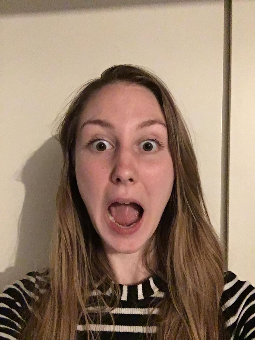

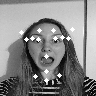

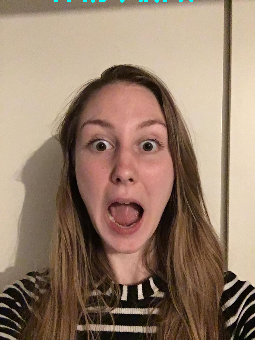

In [29]:
%cd /gdrive/My Drive/Lab Project

# an image of myself I uploaded to my gdrive
img = cv.imread('challenge')
cv2_imshow(cv.resize(img,(255,340)))
draw_keypoints2(img,model_custom.predict)
  

/gdrive/My Drive/Lab Project


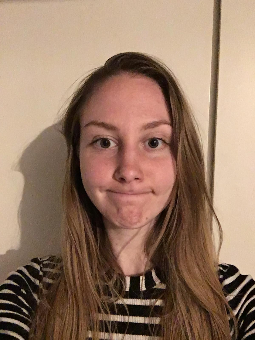

[[277 422 665 665]]


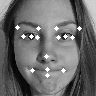

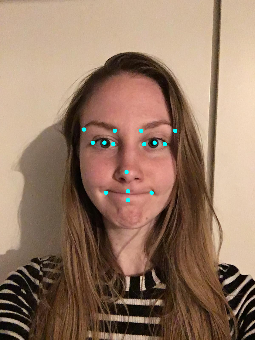

In [13]:
%cd /gdrive/My Drive/Lab Project

# an image of myself I uploaded to my gdrive
img = cv.imread('Libby_Photo')
cv2_imshow(cv.resize(img,(255,340)))
draw_keypoints(img,model_custom.predict)
  

/gdrive/My Drive/Colab Notebooks/ML-Lab-Facial-Keypoint-Detection


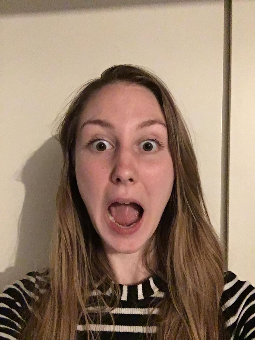

error: ignored

In [0]:
%cd /gdrive/My Drive/Colab Notebooks/ML-Lab-Facial-Keypoint-Detection

img = cv.imread('me.jpg')
cv2_imshow(cv.resize(img,(255,340)))
draw_keypoints(img,model_custom.predict)